In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
plt.style.use('seaborn-ticks')
import matplotlib.patches as patches

In [2]:
import os, random
import cv2

from tqdm.auto import trange

# Data Exploration

In [3]:
images_path = "../face_mask_dataset/Medical Mask/images"
annotations_path = "../face_mask_dataset/Medical Mask/annotations"
train = pd.read_csv("../face_mask_dataset/train.csv")
submission = pd.read_csv("../face_mask_dataset/submission.csv")

In [4]:
print(len(train))
train.head()

15412


,name,x1,x2,y1,y2,classname
0,2756.png,69,126,294,392,face_with_mask
1,2756.png,505,10,723,283,face_with_mask
2,2756.png,75,252,264,390,mask_colorful
3,2756.png,521,136,711,277,mask_colorful
4,6098.jpg,360,85,728,653,face_no_mask


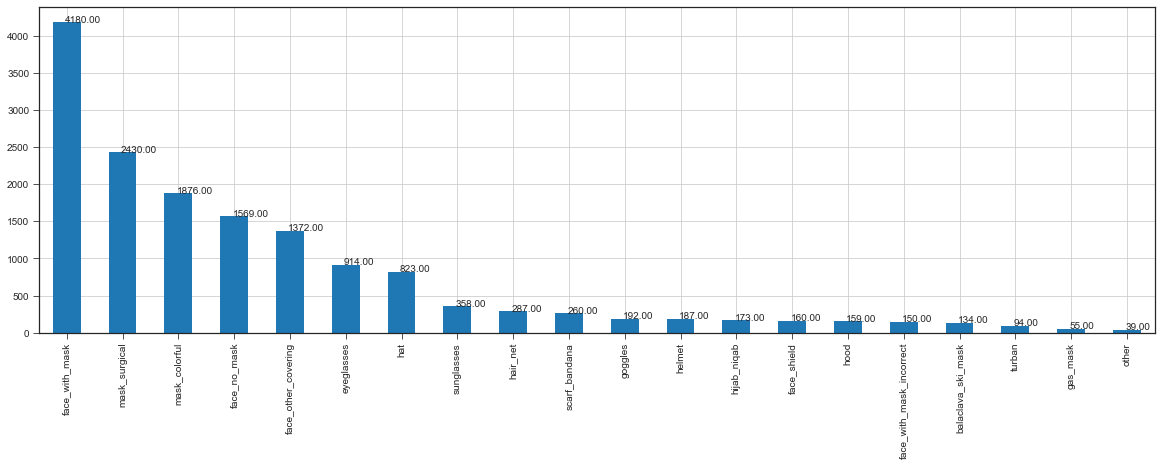

In [5]:
fig, ax = plt.subplots(figsize=(20, 6))

train['classname'].value_counts().plot.bar()
ax.grid()
x_offset = -0.03
y_offset = 0.05
for p in ax.patches:
    b = p.get_bbox()
    val = "{:.2f}".format(b.y1 + b.y0)        
    ax.annotate(val, ((b.x0 + b.x1)/2 + x_offset, b.y1 + y_offset))

In [6]:
len(os.listdir(images_path))

6024

In [7]:
images = os.listdir(images_path)
annotations = os.listdir(annotations_path)
images.sort()
annotations.sort()
print(len(annotations),len(images))

4326 6024


In [8]:
train_images = images[1698:]
test_images = images[:1698]

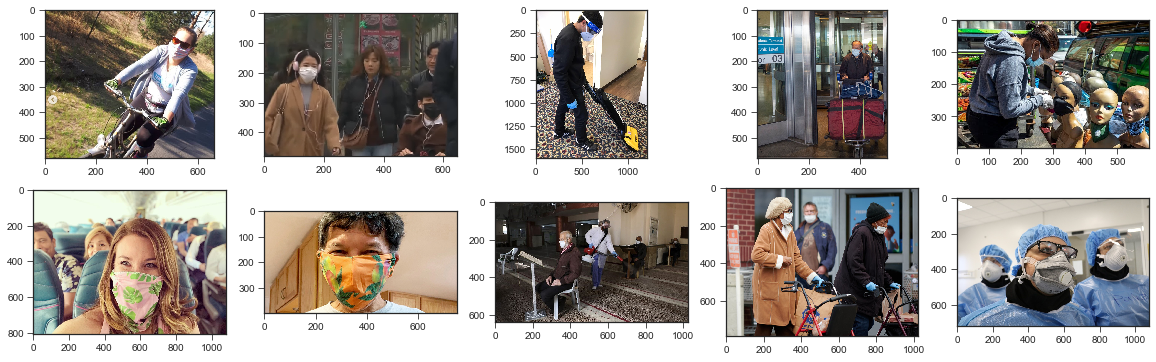

In [9]:
img_tr = random.choices(train_images, k=5)
img_ts = random.choices(test_images, k=5)

fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(20, 6))
for i in range(5):
    ax[0][i].imshow(plt.imread(os.path.join(images_path,img_tr[i])))
    ax[1][i].imshow(plt.imread(os.path.join(images_path,img_ts[i])))

In [10]:
train= train[train['classname'].isin(['face_with_mask','face_no_mask'])]
train.sort_values('name',axis=0,inplace=True)

In [11]:
bbox=[]
for i in range(len(train)):
    arr=[]
    for j in train.iloc[i][["x1",'x2','y1','y2']]:
        arr.append(j)
    bbox.append(arr)
train["bbox"]=bbox 

def get_boxes(id):
    boxes=[]
    for i in train[train["name"]==str(id)]["bbox"]:
        boxes.append(i)
    return boxes

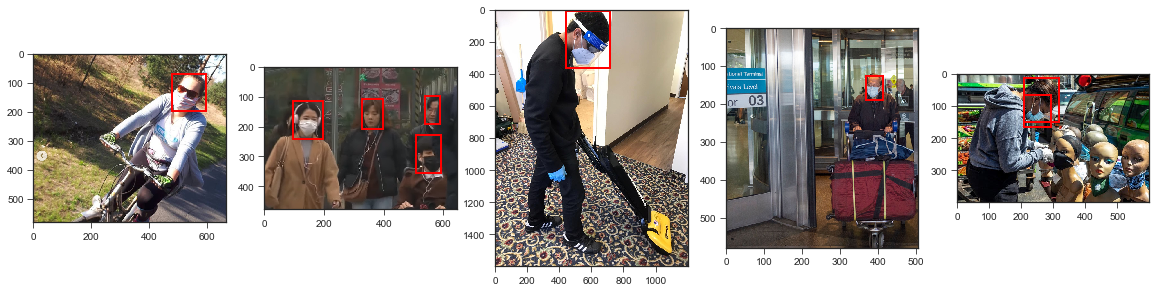

In [12]:
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(20, 6))
for i in range(5):
    ax[i].imshow(plt.imread(os.path.join(images_path,img_tr[i])))
    boxes = get_boxes(img_tr[i])
    for box in boxes:
        rect = patches.Rectangle((box[0],box[1]),box[2]-box[0],box[3]-box[1],linewidth=2,edgecolor='r',facecolor='none')
        ax[i].add_patch(rect)

# Preparing Data

In [13]:
from keras.utils import normalize, to_categorical

img_size = (96, 96, 1)

Using TensorFlow backend.


In [14]:
X = []
y = []

for i in trange(len(train)):
    row = train.iloc[i].values
    img = cv2.imread(os.path.join(images_path,row[0]), cv2.IMREAD_GRAYSCALE)
    img = img[row[2]:row[4], row[1]:row[3]]
    img = cv2.resize(img, img_size[:2])
    X.append(img)
    if row[5] == 'face_with_mask':
        y.append(0)
    elif row[5] == 'face_no_mask':
        y.append(1)
    else:
        print('error')

In [15]:
X = np.array(X).reshape(-1, 96, 96, 1)
X = normalize(X, axis=1)

y = to_categorical(y)

# Modelling

In [16]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.utils import plot_model
from keras.optimizers import Adam

In [17]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
filepath = "face_mask_model.h5"
ckpt = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
rlp = ReduceLROnPlateau(monitor='loss', patience=3, factor=0.2)

opt = Adam(lr=0.001, decay=0.000001)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 96, 96, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 64)        256       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 64)       

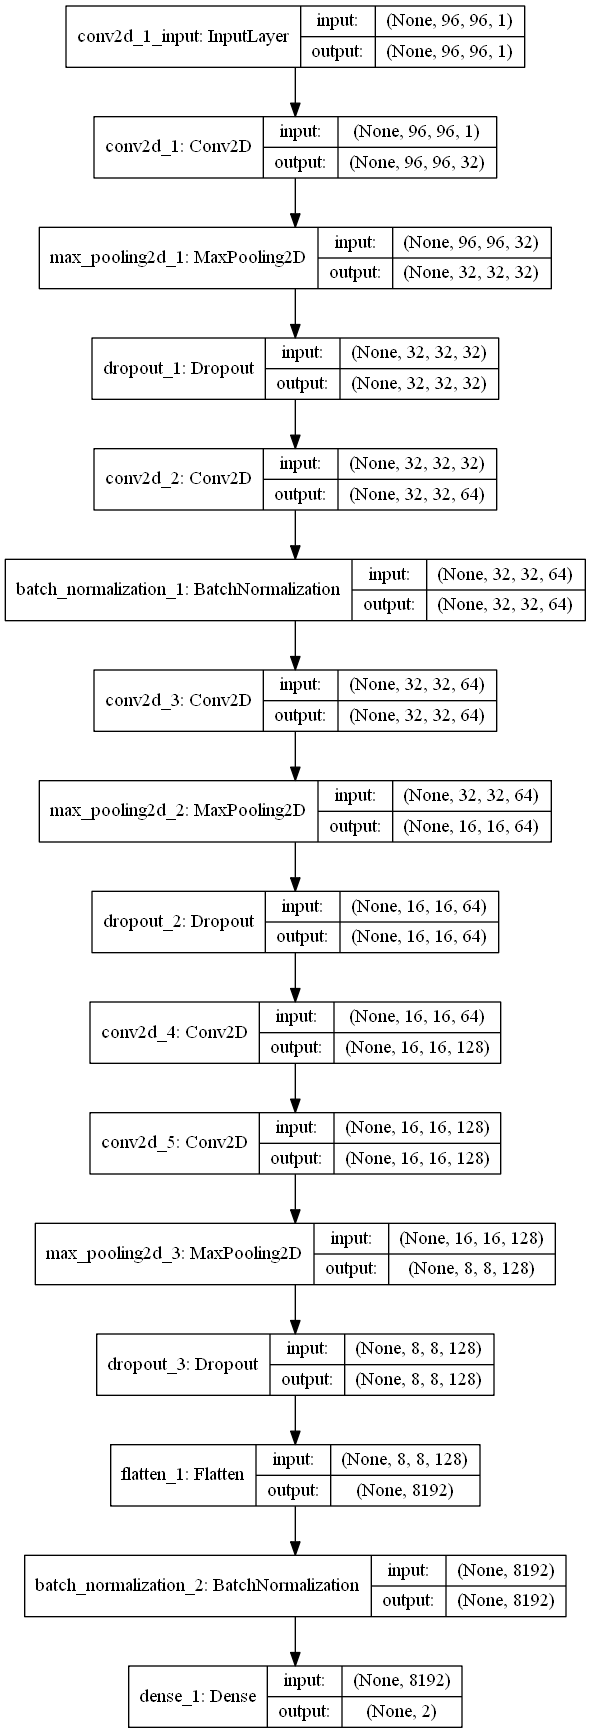

In [18]:
def cnn(image_size):
    classifier = Sequential()
    classifier.add(Conv2D(32, (3, 3), input_shape=image_size, activation='relu', padding='same'))
#     classifier.add(BatchNormalization(axis=-1))
    classifier.add(MaxPooling2D(pool_size = (3, 3)))
    classifier.add(Dropout(0.25))
    
    classifier.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    classifier.add(BatchNormalization(axis=-1))
    
    classifier.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
#     classifier.add(BatchNormalization(axis=-1))
    classifier.add(MaxPooling2D(pool_size = (2, 2)))
    classifier.add(Dropout(0.25))
    
    classifier.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
#     classifier.add(BatchNormalization(axis=-1))
    
    classifier.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
#     classifier.add(BatchNormalization(axis=-1))
    classifier.add(MaxPooling2D(pool_size = (2, 2)))
    classifier.add(Dropout(0.25))
    
    classifier.add(Flatten())
#     classifier.add(Dense(1024, activation='relu'))
    classifier.add(BatchNormalization())
#     classifier.add(Dropout(0.5))
    classifier.add(Dense(units = 2, activation = 'sigmoid'))
    classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['acc'])
    return classifier

neuralnetwork = cnn(img_size)
neuralnetwork.summary()

plot_model(neuralnetwork, to_file="face_mask_model.png", show_shapes=True)

In [19]:
history = neuralnetwork.fit(
    x=X, y=y,
    validation_split = 0.05, batch_size=5,
    callbacks=[es, ckpt, rlp], epochs = 1000, 
    class_weight={0:1, 1:2.664}
)

Train on 5461 samples, validate on 288 samples
Epoch 1/1000
5461/5461 [==============================] - 117s 21ms/step - loss: 1.1210 - acc: 0.6372 - val_loss: 2.9885 - val_acc: 0.4323

Epoch 00001: loss improved from inf to 1.12099, saving model to face_mask_model.h5
Epoch 2/1000
5461/5461 [==============================] - 115s 21ms/step - loss: 1.0898 - acc: 0.6614 - val_loss: 0.9550 - val_acc: 0.7969

Epoch 00002: loss improved from 1.12099 to 1.08984, saving model to face_mask_model.h5
Epoch 3/1000
5461/5461 [==============================] - 114s 21ms/step - loss: 1.1348 - acc: 0.6448 - val_loss: 2.0769 - val_acc: 0.5434

Epoch 00003: loss did not improve from 1.08984
Epoch 4/1000
5461/5461 [==============================] - 117s 22ms/step - loss: 1.0250 - acc: 0.6735 - val_loss: 5.1261 - val_acc: 0.2049

Epoch 00004: loss improved from 1.08984 to 1.02505, saving model to face_mask_model.h5
Epoch 5/1000
5461/5461 [==============================] - 116s 21ms/step - loss: 1.0408 -

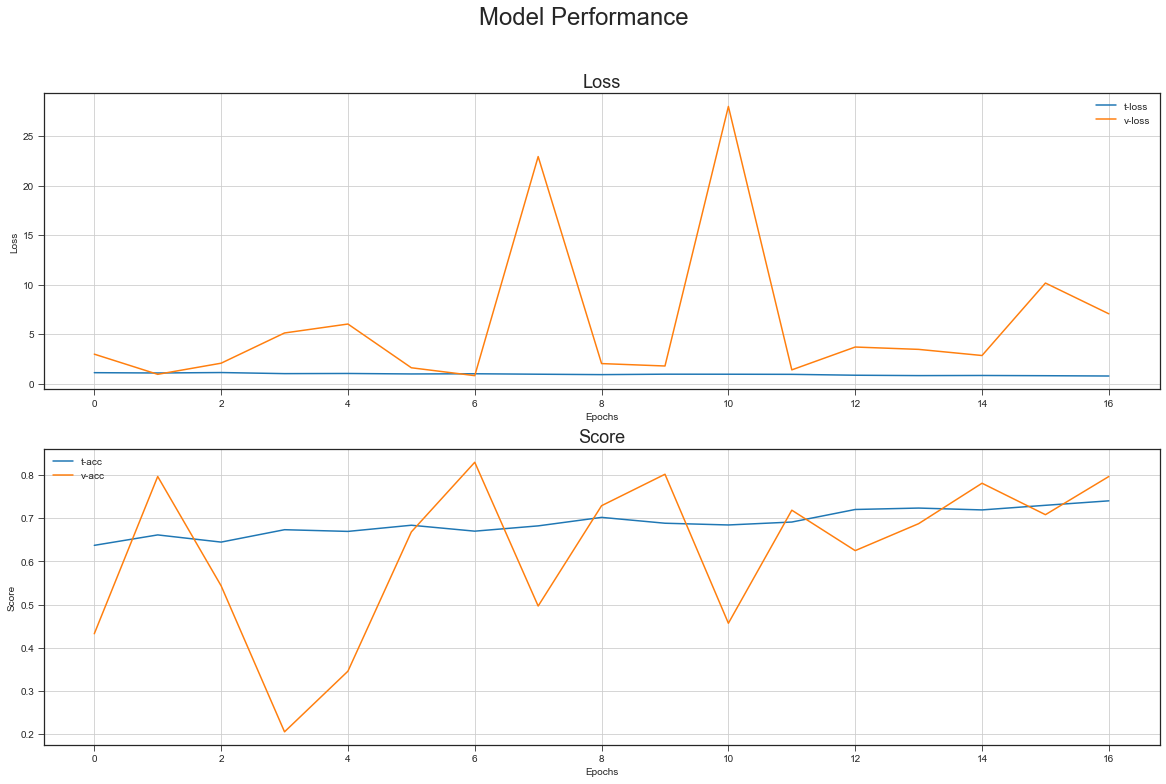

In [20]:
fig, ax = plt.subplots(2, 1, figsize=(20, 12))

fig.suptitle('Model Performance', fontsize=24) 

ax[0].plot(history.history['loss'], label='t-loss')
ax[0].plot(history.history['val_loss'], label='v-loss')
ax[0].set_title('Loss', fontsize=18)
ax[0].set_ylabel('Loss')

ax[1].plot(history.history['acc'], label='t-acc')
ax[1].plot(history.history['val_acc'], label='v-acc')
ax[1].set_title('Score', fontsize=18)
ax[1].set_ylabel('Score')


for i in range(2):
    ax[i].grid()
    ax[i].legend()
    ax[i].set_xlabel('Epochs')